** If you like my notebook, please upvote my work!**

**If you use parts of this notebook in your scripts/notebooks, giving some kind of credit for instance link back to this notebook would be very much appreciated. Thanks in advance! :) **


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv


# Importing important libraries

In [2]:
import calendar
import seaborn as sb
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV

# Loading the training dataset

In [3]:
#Reading the file
df_train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

In [4]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Checking for null values

In [5]:
df_train.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No data cleaning is required since no Null values are found!

In [6]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

# Data visualization:

## Heatmap of all the continuous values in the file.

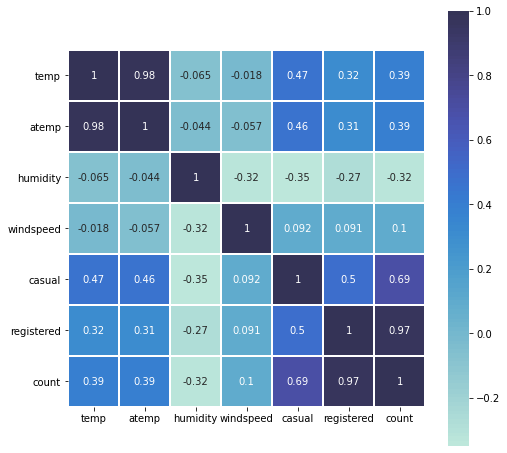

In [7]:
corr = df_train[['temp','atemp','humidity', 'windspeed','casual', 'registered',
                 'count']].corr()
f,axes = plt.subplots(1,1,figsize = (8,8))
sb.heatmap(corr,square=True,annot = True,linewidth = .5,center = 1.4,ax = axes)

## Line plot for all continuous values in file 

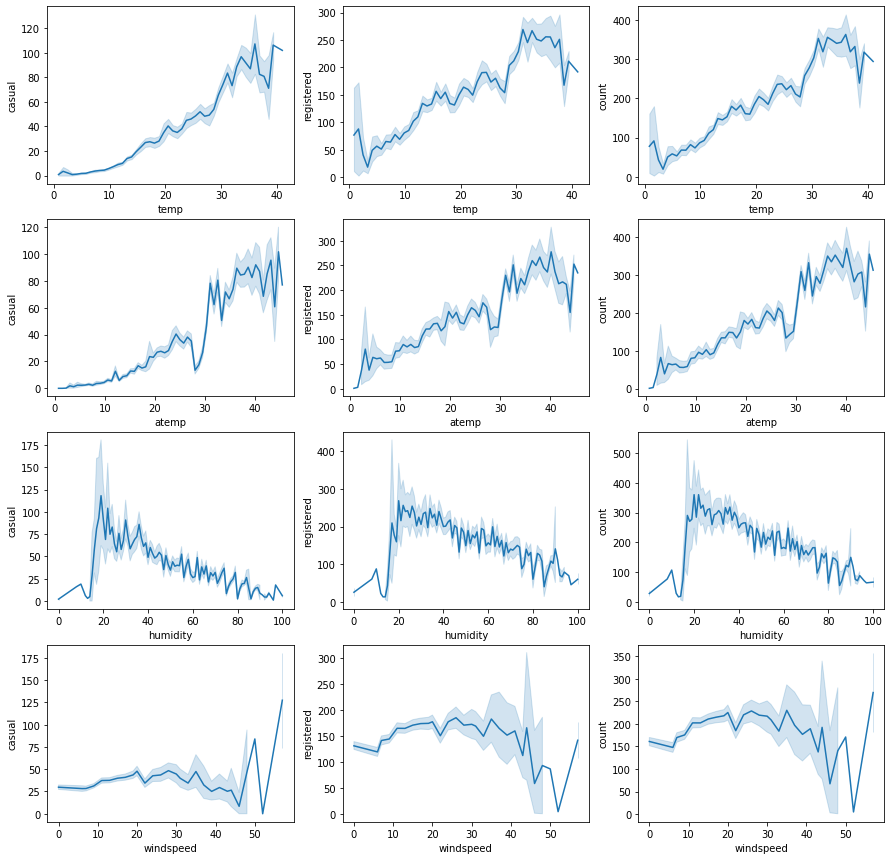

In [8]:
y = ['casual','registered','count']
list_continuous = ['temp','atemp','humidity','windspeed']
n=3
s= 15
f,axes = plt.subplots(4,3,figsize = (s,s))
counter = 0
for i in list_continuous:
    for j in y:
        sb.lineplot(x = i , y = j , data  = df_train, ax = axes[counter//n][counter%n])
        counter+=1

### The conclusions drawn are:
1. We can see that temp and atemp have a very strong positive correlation therefore we can use drop atemp as a variable without any loss of information. 

2. We can infer from the correlaton matrix and lineplots that windspeed has no significant correlation with the casual,registered or count which we wish to predict so we can remove that

## Data visualizaton for non continuous variables in data

First we have to separate the individual date and time for each data point into hour,day,month and year.

In [9]:
df_train['Date'] = pd.DatetimeIndex(df_train['datetime']).date
df_train['Hour'] = pd.DatetimeIndex(df_train['datetime']).hour
df_train['Day'] = pd.DatetimeIndex(df_train['datetime']).day
df_train['Month'] = pd.DatetimeIndex(df_train['datetime']).month
df_train['Year'] = pd.DatetimeIndex(df_train['datetime']).year
df_train['Weekday'] = pd.DatetimeIndex(df_train['datetime']).weekday_name

In [10]:
a = []
for i in df_train.index:
    a.append('Total Count : '+str(df_train['count'][i]))
df_train['count_vis'] = a

In [11]:
fig = px.line(x = 'Date', y = "count", data_frame = df_train,color = 'Hour',
              range_y = (0,1150),hover_data = ['Hour','Date','casual','registered'],
              title = 'Interactive LinePlot of the whole dataset(Hover for more details)',
              hover_name = 'count_vis', text = None,height = 670,width = 980)
fig.show()

**The sudden periodic changes between the differrent regions is due to the missing data.These are the regions in which the regions we have to predict the result.**

## 1. Season

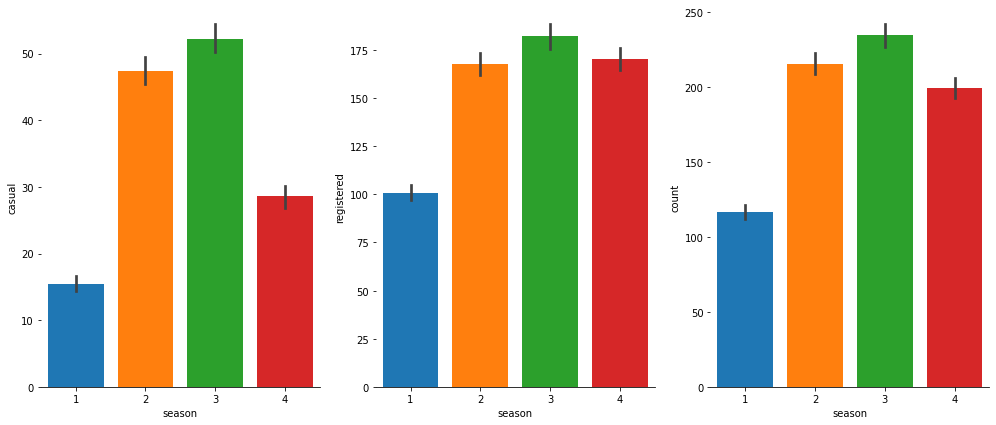

In [12]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'season'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

## 2. Holiday

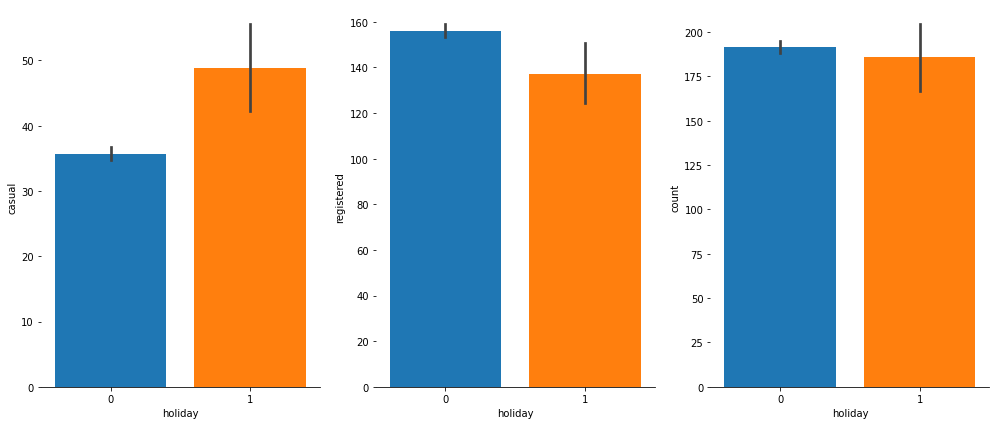

In [13]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'holiday'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

## 3. Working day

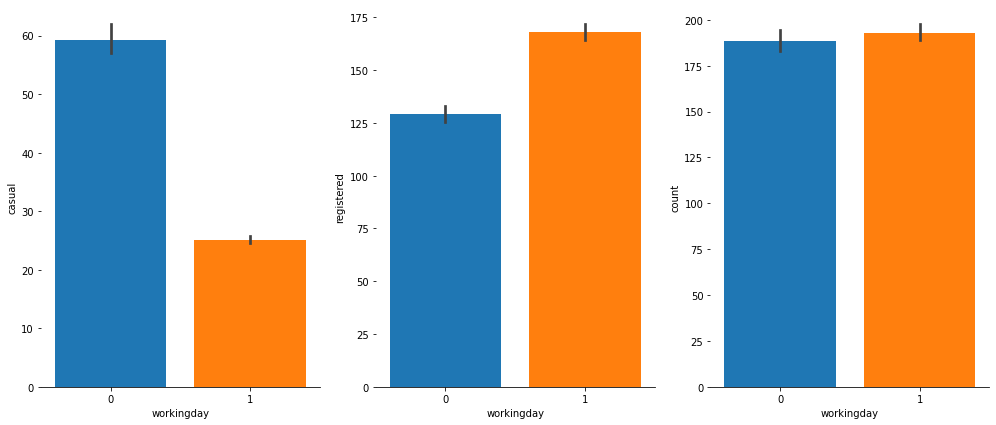

In [14]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'workingday'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

Combining the graphs of casual and registered into one of may make it seem like that holiday and workingday have no dependence on count but we can clearly see that holiday increases the casual amount by upto 40% and a reverse kind of trend is observed in working day so it is reasonable to take two different models one for casual and another for registered.

Therefore what I will attempt to do is make two separate models for the casual and the registerd training them separately and then adding the result to get the count.

## 4. Weather

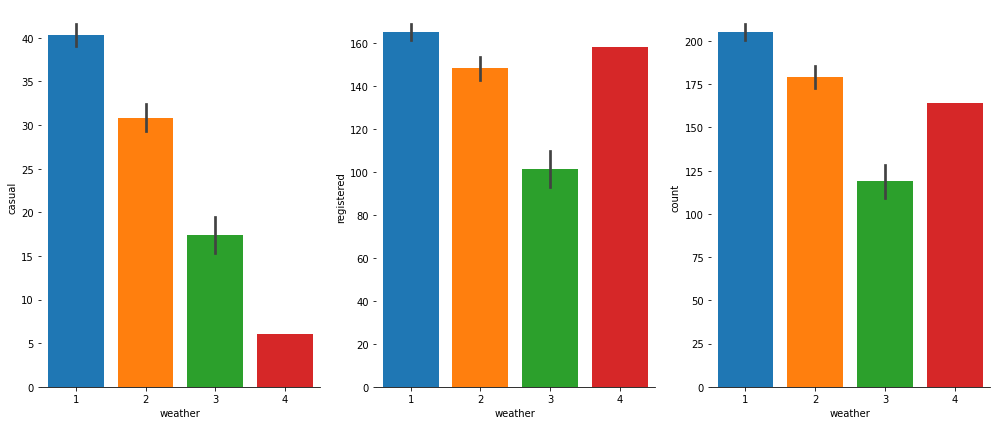

In [15]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'weather'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0] )
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

## 5. Date and Time

### 5.a. Hour

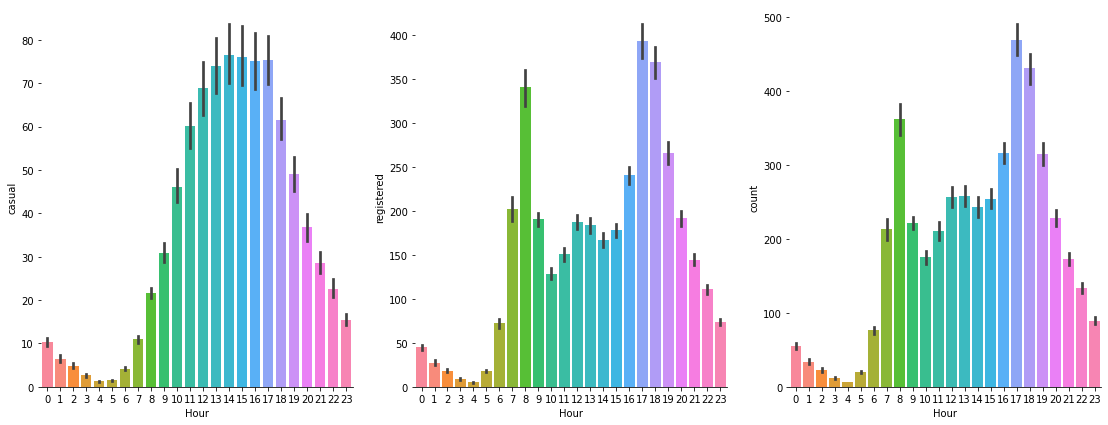

In [16]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Hour'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

We can see that in the final graph there are two prominent peaks.
1. At 8 a.m
2. At 5 p.m
Where as the trend of casual is mostly the same throughout the day. 

**From this we can conclude that the registered are mostly people going on their jobs which explains the peaks at the start and end of office hours. Clearly these people would have a more definite and predictible schedule and are therefore more likely to be registered.** In order to test this hypothesis we plot some more graphs.

In [17]:
df_train.groupby('Weekday').count().index

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object', name='Weekday')

In [18]:
df_train_temp = df_train.groupby(['Hour','Weekday']).mean().reset_index()
dic = {'Weekday':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                  'Sunday']}
dic1 = {'registered':'Average count of registered poeple commuting.',
        'count': 'Average people commuting','Hour':'Hour of the day',
        'Weekday':'Day of the week'}
fig = px.line(x = 'Hour', y = "registered", data_frame = df_train_temp.reset_index(),
              color = 'Weekday',hover_data = ['count'],category_orders = dic,
              title = 'Interactive LinePlot of the registered separated by weekday(Hover for more details)',
              labels = dic1,range_y = [0,550],height = 670,width = 980)
fig.show()

Clearly We can see that on the days of saturday and sunday,the general trend more or less follows the same trend as of casual where as on weekdays there is a completely different trend of two peaks at 8 am and 5 pm which confirms that those peaks are due to the workpeople commuting.

In [19]:
df_train_temp = df_train.groupby(['Hour','Weekday']).mean().reset_index()
dic = {'Weekday':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                  'Sunday']}
dic1 = {'casual':'Average count of casual poeple commuting.',
        'count': 'Average people commuting','Hour':'Hour of the day',
        'Weekday':'Day of the week'}
fig = px.line(x = 'Hour', y = "casual", data_frame = df_train_temp.reset_index(),
              color = 'Weekday',hover_data = ['count'],category_orders = dic,
              title = 'Interactive LinePlot of the casual separated by weekday(Hover for more details)',
              labels = dic1,range_y = [0,550],height = 670,width = 980)
fig.show()

We can observe that on the days of saturday and sunday,there is a surge in the demand. This makes sense as these days are holidays for most of the poeple which results in higher people commuting (probably for leisure activities).

### 5.b. Day

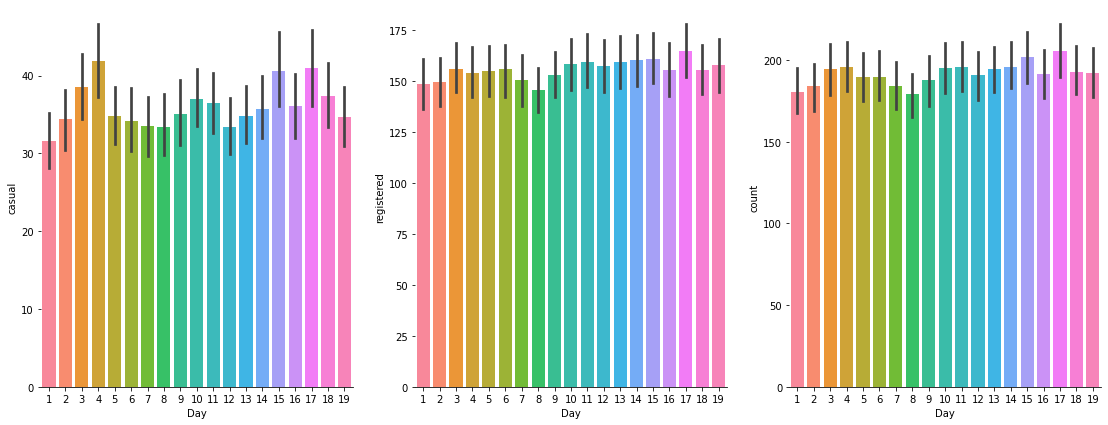

In [20]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Day'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

**From the above graphs we can conclude that the feature day has hardly any influence over the features registered and count.**

### 5.c. Month

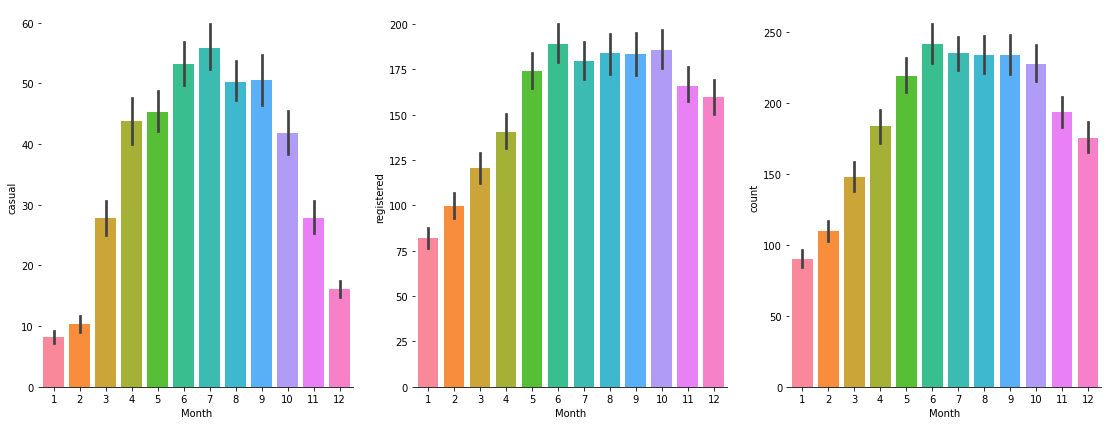

In [21]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Month'
#order = ['January','February','March','April','May','June','July','August','September','October','November','December']
plot = sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

### 5.d. Year 

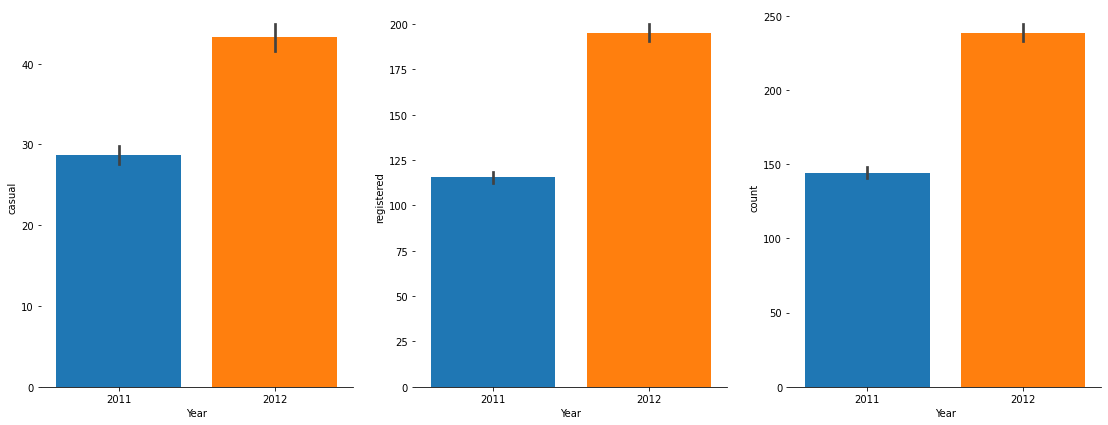

In [22]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Year'

sb.barplot(x = x , y = 'casual' , data = df_train, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = df_train, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = df_train, saturation = 1, ax = axes[2])

We can see that overal the company made growth from the year 2011 to the year 2012.

In [23]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Day,Month,Year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,9.992559,6.521495,2011.501929
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,5.476608,3.444373,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,5.000000,4.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,10.000000,7.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,15.000000,10.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,19.000000,12.000000,2012.000000


In [24]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 'Weekday', 'count_vis'],
      dtype='object')

# One Hot Encoding for each of the categorical data columns and removing unnecesary ones

## 1. Season

In [25]:
for i in df_train.groupby('season').count().index:
    s = 's'+str(i)
    a=[]
    for j in df_train.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    df_train[s]=a
df_train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour,Day,Month,Year,Weekday,count_vis,s1,s2,s3,s4
6974,2012-04-08 22:00:00,2,0,0,1,20.50,24.240,36,15.0013,33,...,22,8,4,2012,Sunday,Total Count : 118,0,1,0,0
3460,2011-08-14 02:00:00,3,0,0,3,26.24,28.790,89,15.0013,13,...,2,14,8,2011,Sunday,Total Count : 62,0,0,1,0
4260,2011-10-09 13:00:00,4,0,0,1,27.06,31.060,44,6.0032,225,...,13,9,10,2011,Sunday,Total Count : 418,0,0,0,1
4965,2011-11-19 23:00:00,4,0,0,1,15.58,19.695,62,15.0013,20,...,23,19,11,2011,Saturday,Total Count : 93,0,0,0,1
10381,2012-11-17 23:00:00,4,0,0,2,12.30,15.910,70,7.0015,19,...,23,17,11,2012,Saturday,Total Count : 133,0,0,0,1


## 2. Weather 

In [26]:
for i in df_train.groupby('weather').count().index:
    s = 'w'+str(i)
    a=[]
    for j in df_train.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    df_train[s]=a
df_train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Weekday,count_vis,s1,s2,s3,s4,w1,w2,w3,w4
7257,2012-05-01 18:00:00,2,0,1,1,28.70,32.575,54,8.9981,81,...,Tuesday,Total Count : 743,0,1,0,0,1,0,0,0
7581,2012-05-15 06:00:00,2,0,1,3,22.96,26.515,94,15.0013,2,...,Tuesday,Total Count : 24,0,1,0,0,0,0,1,0
7829,2012-06-06 14:00:00,2,0,1,1,26.24,31.060,38,0.0000,111,...,Wednesday,Total Count : 302,0,1,0,0,1,0,0,0
7202,2012-04-18 11:00:00,2,0,1,3,18.86,22.725,47,16.9979,14,...,Wednesday,Total Count : 119,0,1,0,0,0,0,1,0
2753,2011-07-03 15:00:00,3,0,0,1,34.44,40.150,53,19.9995,194,...,Sunday,Total Count : 376,0,0,1,0,1,0,0,0


## 3. Hour

In [27]:
for i in df_train.groupby('Hour').count().index:
    s = 'Hour'+str(i)
    a=[]
    for j in df_train.Hour:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    df_train[s]=a
df_train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23
1532,2011-04-09 17:00:00,2,0,0,2,15.58,19.695,82,6.0032,128,...,0,0,0,1,0,0,0,0,0,0
528,2011-02-05 04:00:00,1,0,0,3,9.02,11.365,93,8.9981,0,...,0,0,0,0,0,0,0,0,0,0
7641,2012-05-17 18:00:00,2,0,1,1,27.06,31.060,27,11.0014,134,...,0,0,0,0,1,0,0,0,0,0
6652,2012-03-14 11:00:00,1,0,1,2,25.42,31.060,41,11.0014,65,...,0,0,0,0,0,0,0,0,0,0
9503,2012-09-19 08:00:00,3,0,1,1,21.32,25.000,59,15.0013,39,...,0,0,0,0,0,0,0,0,0,0


## 4.Month

In [28]:
for i in df_train.groupby("Month").count().index:
    s = 'Month' + str(i)
    a = []
    for j in df_train.Month:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    df_train[s] = a
df_train.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
3293,2011-08-07 03:00:00,3,0,0,2,28.70,33.335,84,8.9981,9,...,0,0,0,0,0,1,0,0,0,0
7854,2012-06-07 15:00:00,2,0,1,1,30.34,32.575,30,0.0000,99,...,0,0,0,1,0,0,0,0,0,0
5171,2011-12-09 13:00:00,4,0,1,1,15.58,19.695,50,12.9980,27,...,0,0,0,0,0,0,0,0,0,1
5706,2012-01-12 22:00:00,1,0,1,1,15.58,19.695,76,19.9995,12,...,0,0,0,0,0,0,0,0,0,0
186,2011-01-09 01:00:00,1,0,0,1,4.10,3.030,42,31.0009,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 'Weekday', 'count_vis', 's1',
       's2', 's3', 's4', 'w1', 'w2', 'w3', 'w4', 'Hour0', 'Hour1', 'Hour2',
       'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10',
       'Hour11', 'Hour12', 'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17',
       'Hour18', 'Hour19', 'Hour20', 'Hour21', 'Hour22', 'Hour23', 'Month1',
       'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7', 'Month8',
       'Month9', 'Month10', 'Month11', 'Month12'],
      dtype='object')

## Removing unnecessary columns

In [30]:
df_train = df_train[['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23','Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12','Year','s1','s2','s3','s4','holiday','workingday',
        'w1','w2','w3','w4','temp','humidity','casual','registered']]

In [31]:
df_train.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,holiday,workingday,w1,w2,w3,w4,temp,humidity,casual,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460,36.021955,155.552177
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033,49.960477,151.039033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000,4.000000,36.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000,17.000000,118.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000,49.000000,222.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000,367.000000,886.000000


In [32]:
df_train.columns

Index(['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7',
       'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
       'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 'Hour21',
       'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3', 'Month4', 'Month5',
       'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12',
       'Year', 's1', 's2', 's3', 's4', 'holiday', 'workingday', 'w1', 'w2',
       'w3', 'w4', 'temp', 'humidity', 'casual', 'registered'],
      dtype='object')

In [33]:
df_train.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,holiday,workingday,w1,w2,w3,w4,temp,humidity,casual,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460,36.021955,155.552177
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033,49.960477,151.039033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000,4.000000,36.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000,17.000000,118.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000,49.000000,222.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000,367.000000,886.000000


# Preparing training and testing sets

### 1. Training set

In [34]:
df_train_x = df_train.drop('casual',axis = 1).drop('registered',axis=1)
df_train_x.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,s3,s4,holiday,workingday,w1,w2,w3,w4,temp,humidity
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.251056,0.251148,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.433641,0.433694,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000


Training set will be the same for both the models.

### 2. Training set

In [35]:
df_reg_train_y = df_train['registered']
df_reg_train_y.describe

<bound method NDFrame.describe of 0         13
1         32
2         27
3         10
4          1
        ... 
10881    329
10882    231
10883    164
10884    117
10885     84
Name: registered, Length: 10886, dtype: int64>

In [36]:
df_cas_train_y = df_train['casual']
df_cas_train_y.describe

<bound method NDFrame.describe of 0         3
1         8
2         5
3         3
4         0
         ..
10881     7
10882    10
10883     4
10884    12
10885     4
Name: casual, Length: 10886, dtype: int64>

# Machine learning model

### Splitting data into train and test sets

In [37]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train_x, df_reg_train_y,
                                                        test_size=0.15, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(df_train_x, df_cas_train_y,
                                                        test_size=0.15, random_state=42)

### Using polynomial on the dataset

In [38]:
poly = PolynomialFeatures(degree=2)
poly_x1_train = poly.fit_transform(x1_train)
poly_x1_test = poly.fit_transform(x1_test)
poly_x2_train = poly.fit_transform(x2_train)
poly_x2_test = poly.fit_transform(x2_test)

### Trying different models to see which one works best for the given data.

In [39]:
rf = RandomForestRegressor()
xg = xgb.XGBRegressor()
parameter = {"max_depth": [1,2,3,4,5,6],
             "eta": [0.01,0.03,0.05],
             "alpha":[0],'n_estimators': [100,500,800,1000,1200,1400]}

parameters = {'n_estimators':[50,100,150,200,250],
              'min_impurity_decrease':[0.0,0.001,0.01],
              'max_depth':[20,40,60,80,100]}

models = ['Normal Linear Regression: ','Linear Regression over polynomial: ',
          'Random Forest Regressor: ','XG Boosting: ']

### Defining a custom scorer function for the models

In [40]:
def custom_scorer(y_true,y_pred):
    for i in range(len(y_pred)):
        if y_pred[i]<0:
            y_pred[i] = 1
    return np.sqrt(mean_squared_log_error(y_true, y_pred ))
scorer = make_scorer(custom_scorer,greater_is_better = False)

Here I have defined a scorer function as we are using mean squared log loss which does not work on negative values and the models were sometimes predicting negative values which messes with the scores and since we know that these values will always be positive we just replace them with the minimum value in the train set which is 1.

## Using different models for registered

In [41]:
predict = []
reg = LinearRegression().fit(x1_train, y1_train)
pre_reg = reg.predict(x1_test)

reg_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg_poly = reg_poly.predict(poly_x1_test)

rf_reg = GridSearchCV(rf, parameters, cv=5, verbose=2,scoring = scorer,n_jobs = -1)
rf_reg.fit(x1_train, y1_train)
pre_rf_reg = rf_reg.predict(x1_test)

xg_reg = GridSearchCV(xg,parameter,cv=5,verbose = 2 , scoring = scorer, n_jobs = -1)
xg_reg.fit(x1_train, y1_train)
pre_xg_reg = xg_reg.predict(x1_test)

predict.append(pre_reg)
predict.append(pre_reg_poly)
predict.append(pre_rf_reg)
predict.append(pre_xg_reg)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 13.7min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 32.5min finished


In [42]:
for prediction in range(len(predict)):
    pre = []
    for p in predict[prediction]:
        if p < 1:
            pre.append(1)
        else:
            pre.append(p)
    print(models[prediction]+str(np.sqrt(mean_squared_log_error(y1_test, pre ))))

Normal Linear Regression: 1.004323087654508
Linear Regression over polynomial: 0.6565935912143859
Random Forest Regressor: 0.41142182410326483
XG Boosting: 0.4477612984841335


We can therefore conclude that the Random Forest Model works best for predicting registered.

## Using different models for casual 

In [43]:
predict = []
cas = LinearRegression().fit(x2_train, y2_train)
pre_cas = cas.predict(x2_test)

cas_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_cas_poly = cas_poly.predict(poly_x2_test)

rf_cas = GridSearchCV(rf, parameters, cv=5, verbose=2,scoring = scorer,n_jobs = -1)
rf_cas.fit(x2_train, y2_train)
pre_rf_cas = rf_cas.predict(x2_test)

xg_cas = GridSearchCV(xg,parameter,cv=5,verbose = 2 , scoring = scorer, n_jobs = -1)
xg_cas.fit(x2_train, y2_train)
pre_xg_cas = xg_cas.predict(x2_test)

predict.append(pre_cas)
predict.append(pre_cas_poly)
predict.append(pre_rf_cas)
predict.append(pre_xg_cas)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 12.5min finished


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 32.6min finished


In [44]:
for prediction in range(len(predict)):
    pre = []
    for p in predict[prediction]:
        if p < 1:
            pre.append(1)
        else:
            pre.append(p)
    print(models[prediction]+str(np.sqrt(mean_squared_log_error(y2_test, pre ))))

Normal Linear Regression: 1.021087822864223
Linear Regression over polynomial: 0.8901384204865517
Random Forest Regressor: 0.6561438305389902
XG Boosting: 0.6251570572327928


We can therefore conclude that the XGBoost Model works best for predicting casual.

In [45]:
print("For Random Forest Model: ")
print("\t Best Parametres for registered are: ",end='')
print(rf_reg.best_params_)
print("\t Best Parametres for casual are: ",end = '')
print(rf_cas.best_params_)
print("\nFor XGBoost Model: ")
print("\t Best Parametres for registered are: ",end='')
print(xg_reg.best_params_)
print("\t Best Parametres for casual are: ",end = '')
print(xg_cas.best_params_)

For Random Forest Model: 
	 Best Parametres for registered are: {'max_depth': 80, 'min_impurity_decrease': 0.001, 'n_estimators': 100}
	 Best Parametres for casual are: {'max_depth': 60, 'min_impurity_decrease': 0.0, 'n_estimators': 250}

For XGBoost Model: 
	 Best Parametres for registered are: {'alpha': 0, 'eta': 0.03, 'max_depth': 6, 'n_estimators': 1200}
	 Best Parametres for casual are: {'alpha': 0, 'eta': 0.05, 'max_depth': 6, 'n_estimators': 800}


# Plotting the residual plots

In [46]:
predict1 = []

reg1 = LinearRegression().fit(x1_train, y1_train)
pre_reg1 = reg1.predict(x1_test)

reg1_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg1_poly = reg1_poly.predict(poly_x1_test)

rf1 = RandomForestRegressor(n_estimators = 250,min_impurity_decrease = 0.001,
                            max_depth=60).fit(x1_train, y1_train)
pre_rf1 = rf1.predict(x1_test)

xg1 = xgb.XGBRegressor(alpha = 0, eta = 0.03, n_estimators = 1200, 
                       max_depth = 6).fit(x1_train,y1_train)
pre_xg1 = xg1.predict(x1_test)

for i in range(pre_reg1.size):
    if pre_reg1[i]<1:
        pre_reg1[i] = 1 
    if pre_reg1_poly[i]<1:
        pre_reg1_poly[i] = 1
    if pre_rf1[i]<1:
        pre_rf1[i] = 1
    if pre_xg1[i]<1:
        pre_xg1[i] = 1

predict1.append(pre_reg1)
predict1.append(pre_reg1_poly)
predict1.append(pre_rf1)
predict1.append(pre_xg1)

x1_final = x1_test.copy()
x1_final['Output'] = y1_test
x1_final['Linear'] = pre_reg1
x1_final['Lin_poly'] = pre_reg1_poly
x1_final['RF'] = pre_rf1
x1_final['XG'] = pre_xg1
x1_final['Resid'] = y1_test-pre_reg1
x1_final['Resid_poly'] = y1_test-pre_reg1_poly
x1_final['Resid_rf'] = y1_test - pre_rf1
x1_final['Resid_xg'] = y1_test - pre_xg1

for prediction in range(len(predict1)):
    print(models[prediction]+
          str(np.sqrt(mean_squared_log_error(y1_test,predict1[prediction] ))))

Normal Linear Regression: 1.004323087654508
Linear Regression over polynomial: 0.6565935912143859
Random Forest Regressor: 0.41369944590669516
XG Boosting: 0.4477612957061675


In [47]:
predict2 = []

reg2 = LinearRegression().fit(x2_train, y2_train)
pre_reg2 = reg2.predict(x2_test)

reg2_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_reg2_poly = reg2_poly.predict(poly_x2_test)

rf2 = RandomForestRegressor(n_estimators = 100,min_impurity_decrease = 0.001,
                            max_depth=40).fit(x2_train, y2_train)
pre_rf2 = rf2.predict(x2_test)

xg2 = xgb.XGBRegressor(alpha = 0, eta = 0.05, n_estimators = 800,
                       max_depth = 6).fit(x2_train,y2_train)
pre_xg2 = xg2.predict(x2_test)

for i in range(pre_reg2.size):
    if pre_reg2[i]<1:
        pre_reg2[i] = 1 
    if pre_reg2_poly[i]<1:
        pre_reg2_poly[i] = 1
    if pre_rf2[i]<1:
        pre_rf2[i] = 1
    if pre_xg2[i]<1:
        pre_xg2[i] = 1

predict2.append(pre_reg2)
predict2.append(pre_reg2_poly)
predict2.append(pre_rf2)
predict2.append(pre_xg2)

x2_final = x2_test.copy()
x2_final['Output'] = y2_test
x2_final['Linear'] = pre_reg2
x2_final['Lin_poly'] = pre_reg2_poly
x2_final['RF'] = pre_rf2
x2_final['XG'] = pre_xg2
x2_final['Resid'] = y2_test-pre_reg2
x2_final['Resid_poly'] = y2_test-pre_reg2_poly
x2_final['Resid_rf'] = y2_test - pre_rf2
x2_final['Resid_xg'] = y2_test - pre_xg2

for prediction in range(len(predict2)):
    print(models[prediction]+
          str(np.sqrt(mean_squared_log_error(y2_test, predict2[prediction]))))

Normal Linear Regression: 1.021087822864223
Linear Regression over polynomial: 0.8901384204865517
Random Forest Regressor: 0.6583105157104528
XG Boosting: 0.625157056161295


In [48]:
name1 = ['Residual for casual without polynomial features'] *1633
name2 = ['Residual for casual with polynomial features'] *1633
name3 = ['Residual for registered without polynomial features'] *1633
name4 = ['Residual for registered with polynomial features'] *1633
dic = {'Lin': 'Output Predicted using linear model',
       'Lin_poly': 'Output Predicted using polynomial features',
       'RF' : 'Output Predicted using RandomForest Model', 
       'XG': 'Output Predicted using XGBoost Model',
       'Resid':'Deviation from predicted','Output':'Expected Output',
       'Resid_poly':'Deviation from predicted','Resid_rf':'Deviation from predicted',
       'Output':'Expected Output','Resid_xg':'Deviation from predicted'}
fig1 = px.scatter(data_frame = x1_final,x = 'Linear', y = 'Resid',hover_data = ['Output'],
                  labels = dic,hover_name = name3,color_discrete_sequence = ['red'])
fig2 = px.scatter(data_frame = x1_final,x = 'Lin_poly', y = 'Resid_poly',
                  hover_data = ['Output'],labels = dic,hover_name = name4,
                  color_discrete_sequence = ['blue'])
fig3 = px.scatter(data_frame = x2_final,x = 'Linear', y = 'Resid',hover_data = ['Output'],
                  labels = dic,hover_name = name1,color_discrete_sequence = ['darkgreen'])
fig4 = px.scatter(data_frame = x2_final,x = 'Lin_poly', y = 'Resid_poly',
                  hover_data = ['Output'],labels = dic,hover_name = name2,
                  color_discrete_sequence = ['gold'])

trace1 = fig1['data'][0]
trace2 = fig2['data'][0]
trace3 = fig3['data'][0]
trace4 = fig4['data'][0]


fig = make_subplots(rows=2, cols=2,horizontal_spacing =0.1,vertical_spacing  = 0.2,
                    row_titles = ['Linear Model','Polynomial Model'],
                    column_titles = ['Casual','Registered'],
                    x_title = 'Residual plots for Registered and Casual under different models (Hover for more details)')

fig.add_trace(trace3, row=1, col=1)
fig.add_trace(trace4, row=2, col=1)
fig.add_trace(trace1, row=1, col=2)
fig.add_trace(trace2, row=2, col=2)

fig.show()

**Since the residual plots show a conical divergence therefore we can conclude that Linear Regression is definitely not a suitable model for the predicting in the above distribution of data**

In [49]:
name5 = ['Residual for casual using RandomForest Model'] *1633
name6 = ['Residual for casual using XGBoost Model'] *1633
name7 = ['Residual for registered using RandomForest Model'] *1633
name8 = ['Residual for registered using XGBoost Model'] *1633

dic = {'Lin': 'Output Predicted using linear model',
       'Lin_poly': 'Output Predicted using polynomial features',
       'RF' : 'Output Predicted using RandomForest Model',
       'XG': 'Output Predicted using XGBoost Model',
       'Resid':'Deviation from predicted','Output':'Expected Output',
       'Resid_poly':'Deviation from predicted','Resid_rf':'Deviation from predicted',
       'Output':'Expected Output','Resid_xg':'Deviation from predicted'}

fig5 = px.scatter(data_frame = x1_final,x = 'RF', y = 'Resid_rf',hover_data = ['Output'],
                  labels = dic,hover_name = name7,color_discrete_sequence = ['red'])
fig6 = px.scatter(data_frame = x1_final,x = 'XG', y = 'Resid_xg',hover_data = ['Output'],
                  labels = dic,hover_name = name8,color_discrete_sequence = ['blue'])
fig7 = px.scatter(data_frame = x2_final,x = 'RF', y = 'Resid_rf',hover_data = ['Output'],
                  labels = dic,hover_name = name5,color_discrete_sequence = ['darkgreen'])
fig8 = px.scatter(data_frame = x2_final,x = 'XG', y = 'Resid_xg',hover_data = ['Output'],
                  labels = dic,hover_name = name6,color_discrete_sequence = ['gold'])

trace5 = fig5['data'][0]
trace6 = fig6['data'][0]
trace7 = fig7['data'][0]
trace8 = fig8['data'][0]

fig = make_subplots(rows=2, cols=2,horizontal_spacing =0.1,vertical_spacing  = 0.2,
                    row_titles = ['Random Forest','XGBoost'],
                    column_titles = ['Casual','Registered'],
                    x_title = 'Residual plots for Registered and Casual under different models (Hover for more details)')

fig.add_trace(trace5, row=1, col=2)
fig.add_trace(trace6, row=2, col=2)
fig.add_trace(trace7, row=1, col=1)
fig.add_trace(trace8, row=2, col=1)
fig.show()

**Since the residual plots of Random Forest regressor and XGBoost regressor do not show a conical divergence therefore we can conclude that they are suitable model for the predicting in the above distribution of data**

### Retraining the decision tree over the whole dataset for submission.

In [50]:
rf1 = RandomForestRegressor(n_estimators = 200,min_impurity_decrease = 0.001,
                            max_depth=80).fit(df_train_x,df_reg_train_y)
xg2 = xgb.XGBRegressor(alpha = 0, eta = 0.05, max_depth = 6,
                       n_estimators = 800).fit(df_train_x,df_cas_train_y)

# Predicting output over test set

### Reading the test file

In [51]:
df_test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [52]:
test=df_test
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


## Processing of the test file

In [53]:
test['mth'] = pd.DatetimeIndex(test['datetime']).month
test['Year'] = pd.DatetimeIndex(test['datetime']).year
test['dy'] = pd.DatetimeIndex(test['datetime']).day
test['hr'] = pd.DatetimeIndex(test['datetime']).hour

for i in test.groupby("season").count().index:
    s = 's' + str(i)
    a = []
    for j in test.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby("weather").count().index:
    s = 'w' + str(i)
    a = []
    for j in test.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby('hr').count().index:
    s = 'Hour'+str(i)
    a=[]
    for j in test.hr:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s]=a
for i in test.groupby("mth").count().index:
    s = 'Month' + str(i)
    a = []
    for j in test.mth:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
test.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,mth,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
3096,2011-12-26 16:00:00,1,1,0,1,14.76,16.665,43,19.0012,12,...,0,0,0,0,0,0,0,0,0,1
3110,2011-12-27 06:00:00,1,0,1,2,12.30,13.635,61,19.9995,12,...,0,0,0,0,0,0,0,0,0,1
1679,2011-07-24 23:00:00,3,0,0,2,31.16,36.365,70,6.0032,7,...,0,0,0,0,1,0,0,0,0,0
1564,2011-07-20 04:00:00,3,0,1,1,27.88,31.820,83,0.0000,7,...,0,0,0,0,1,0,0,0,0,0
3321,2012-01-24 02:00:00,1,0,1,2,13.12,15.150,93,15.0013,1,...,0,0,0,0,0,0,0,0,0,0
388,2011-02-25 21:00:00,1,0,1,1,11.48,12.880,48,26.0027,2,...,0,0,0,0,0,0,0,0,0,0
22,2011-01-20 22:00:00,1,0,1,2,9.84,10.605,65,19.0012,1,...,0,0,0,0,0,0,0,0,0,0
254,2011-01-31 21:00:00,1,0,1,3,6.56,9.850,59,6.0032,1,...,0,0,0,0,0,0,0,0,0,0
2775,2011-11-24 04:00:00,4,1,0,1,12.30,15.910,61,6.0032,11,...,0,0,0,0,0,0,0,0,1,0
2549,2011-10-26 18:00:00,4,0,1,1,21.32,25.000,77,11.0014,10,...,0,0,0,0,0,0,0,1,0,0


In [54]:
test = test[['Hour0','Hour1','Hour2','Hour3','Hour4','Hour5','Hour6','Hour7','Hour8',
             'Hour9','Hour10','Hour11','Hour12','Hour13','Hour14','Hour15','Hour16',
             'Hour17','Hour18','Hour19','Hour20','Hour21','Hour22','Hour23','Month1',
             'Month2','Month3','Month4','Month5','Month6','Month7','Month8','Month9',
             'Month10','Month11','Month12','Year','s1','s2','s3','s4','holiday',
             'workingday','w1','w2', 'w3','w4','temp','humidity']]
test.describe

<bound method NDFrame.describe of       Hour0  Hour1  Hour2  Hour3  Hour4  Hour5  Hour6  Hour7  Hour8  Hour9  \
0         1      0      0      0      0      0      0      0      0      0   
1         0      1      0      0      0      0      0      0      0      0   
2         0      0      1      0      0      0      0      0      0      0   
3         0      0      0      1      0      0      0      0      0      0   
4         0      0      0      0      1      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
6488      0      0      0      0      0      0      0      0      0      0   
6489      0      0      0      0      0      0      0      0      0      0   
6490      0      0      0      0      0      0      0      0      0      0   
6491      0      0      0      0      0      0      0      0      0      0   
6492      0      0      0      0      0      0      0      0      0      0   

      ...  s3  s4  holiday  w

## Predicting the output over test set

In [55]:
pre_reg = rf1.predict(test)
pre_cas = xg2.predict(test)

final_predictions = pd.DataFrame(pre_cas+pre_reg,columns = ['cout'])

final_predictions.describe

<bound method NDFrame.describe of             cout
0      11.111697
1       4.453529
2       4.167181
3       1.530139
4       2.098004
...          ...
6488  229.137136
6489  158.383158
6490  122.402320
6491   98.657707
6492   60.857349

[6493 rows x 1 columns]>

In [56]:
s=[]
for j in final_predictions.cout:
    if int(j)<1:
        s.append(1)
    else:
        s.append(j)
final_predictions['count'] = s 

**Since we know that the output should never be less than 1, replace all negative values with 1.**

In [57]:
final_predictions.describe

<bound method NDFrame.describe of             cout       count
0      11.111697   11.111697
1       4.453529    4.453529
2       4.167181    4.167181
3       1.530139    1.530139
4       2.098004    2.098004
...          ...         ...
6488  229.137136  229.137136
6489  158.383158  158.383158
6490  122.402320  122.402320
6491   98.657707   98.657707
6492   60.857349   60.857349

[6493 rows x 2 columns]>

In [58]:
final_predictions['datetime']=df_test['datetime']
final_predictions = final_predictions[['datetime','count']]

In [59]:
final_predictions.describe()

,count
count,6493.000000
mean,190.424096
std,172.834968
min,1.000000
25%,51.147832
50%,148.726365
75%,283.055592
max,914.077925


## Exporting output to csv

In [60]:
final_predictions.to_csv('submission.csv',index=False)